In [16]:
%matplotlib inline
from __future__ import division
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.collections import BrokenBarHCollection

import pybedtools as pbt

In [4]:

# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections_original(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
#         print chrom
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']

In [5]:
def chromosome_collections(df, y_positions, height,  cent_buffer=0.3, ideo=False, **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    ideo:default(False)- is this an idiogram plot? in which case, you can choose to shrink the height 
    of the centromeres
    
    cent_buffer:float amount to move up the centromere y_pos, with proportional decrease in
    height to give centromere more distinctive appearance
    
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
        
        
    if ideo==True:
    
        for chrom, group in df.groupby('chrom'):
            
            for stain, g in group.groupby('gieStain'):
#                 print stain
                yrange = ''
                xranges =''
                if stain == 'acen':
                    yrange = (y_positions[chrom] + cent_buffer, height - (cent_buffer*2))
                    xranges = g[['start', 'width']].values
                else:
                    yrange = (y_positions[chrom], height)
                    xranges = g[['start', 'width']].values
                yield BrokenBarHCollection(
                    xranges, yrange, facecolors=g['colors'], **kwargs)
    
    if ideo==False:
        
        for chrom, group in df.groupby('chrom'):
            yrange = (y_positions[chrom], height)
            xranges = group[['start', 'width']].values
            yield BrokenBarHCollection(xranges, yrange, facecolors=group['colors'],  **kwargs)
    
    
    if del_width:
        del df['width']

In [6]:
def prep_ideo(df):
    df = df.copy()
    df['width'] = df.end - df.start
    
    
    color_lookup = {
    'gneg': (1., 1., 1.),
    'gpos25': (.6, .6, .6),
    'gpos50': (.4, .4, .4),
    'gpos75': (.2, .2, .2),
    'gpos100': (0., 0., 0.),
    'acen': (.8, .4, .4),
    'gvar': (.8, .8, .8),
    'stalk': (.9, .9, .9),
}

    # Add a new column for colors
    df['colors'] = df['gieStain'].apply(lambda x: color_lookup[x])


    return df

In [7]:
def format_base_pair_scale(x, log10 = False):
    """ input list of tick locations, output formatted ticks 
    with bp,kbpb, MB annotations - log: if the ticks
    are log scaled- what base is the log scale 
    example: log=10 for log base 10"""
    if log10:
        input_ticks = [(10**i) for i in x]
    else:
        input_ticks = x    
    out = []
    for t in input_ticks: 
        if (t < 1000) and (t > -1000) :
            f = "{}bp".format(t)
        
        elif (t > 100000) or (t < 100000):
            f = "{}MB".format(round((t/1000000), 2))
            
        elif (t > 1000) or (t < 1000):
            f = "{}kb".format(round((t/1000), 1))
            
        else:
            return 'missed case'
        out.append(f)
    
    return out

In [26]:
def draw_ideogram(regions, ideo = None,  chrom_height = 1, chrom_spacing = 1,  gene_height = 1.5, 
                  gene_padding = 0.0, region_to_chrom = 0.5, ax = False, 
                  set_color = '#2243a8', 
                  ideogram_fn = '/frazer01/projects/CARDIPS/analysis/cardips-cnv-analysis/data/ideogram.txt',
                  figsize = (10, 0.5)):

    
    def prep_ideo(df):
        df = df.copy()
        df['width'] = df.end - df.start
        color_lookup = {
        'gneg': (1., 1., 1.),
        'gpos25': (.6, .6, .6),
        'gpos50': (.4, .4, .4),
        'gpos75': (.2, .2, .2),
        'gpos100': (0., 0., 0.),
        'acen': (.8, .4, .4),
        'gvar': (.8, .8, .8),
        'stalk': (.9, .9, .9),
    }

        # Add a new column for colors
        df['colors'] = df['gieStain'].apply(lambda x: color_lookup[x])
        return df

    if type(ideo) != None:
        print 'using default ideogram'
        ideo = pd.read_table(
        idiogram_fn,
        skiprows=1,
        names=['chrom', 'start', 'end', 'name', 'gieStain']).pipe(prep_ideo)

    
    # Width, height (in inches)
    return_fig = False
    if not ax: 
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        return_fig = True
        
    # Decide which chromosomes to use
    
    chroms = regions.chrom.unique()
    chromosome_list = ['chr%s' % i for i in range(1, 23) + ['X', 'Y']]
    chromosome_list=[i for i in chromosome_list if i in chroms]

    # Keep track of the y positions for ideograms and regions for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 10
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - region_to_chrom - gene_padding
        ybase += chrom_height + chrom_spacing


    # Filter out chromosomes not in our list
    ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

    # Same thing for regions

    regions = regions[regions.chrom.apply(lambda x: x in chromosome_list)]
    regions['width'] = regions.end - regions.start
    if 'colors' not in regions.columns:
        regions['colors'] = '#2243a8'

    # Now all we have to do is call our function for the ideogram data...
    # print("adding ideograms...")
    for collection in chromosome_collections(ideo, chrom_ybase, chrom_height, ideo=True, linewidths =2, edgecolors='black'):
        ax.add_collection(collection)

    # ...and the gene data
    print("adding regions...")
    for collection in chromosome_collections(
        regions, gene_ybase, gene_height, alpha=1, linewidths=0.1
    ):
        ax.add_collection(collection)

    # Axes tweaking
    ax.set_yticks([chrom_centers[i] for i in chromosome_list])
    ax.set_yticklabels(chromosome_list, fontsize=12)
    ax.axis('tight')
    xlabs = ax.get_xticks()
    new_xlabs = format_base_pair_scale(xlabs)
    ax.set_xticklabels(new_xlabs)
    
    sns.despine()
    
    if return_fig:
        return fig, ax
    else:
        return ax
    
    

In [12]:
norm_chroms = ['chr%s' % i for i in range(1, 23) + ['X', 'Y']] # normal contigs
chrom_sizes = pd.read_table('/frazer01/projects/CARDIPS/analysis/cardips-cnv-analysis/data/hg19.chrom.sizes', 
                            names=['chrom', 'end'])
chrom_sizes.index= chrom_sizes.chrom
chrom_dict = chrom_sizes.loc[Norm_Chroms].end.to_dict()

In [13]:
idiogram_fn = '/frazer01/projects/CARDIPS/analysis/cardips-cnv-analysis/data/ideogram.txt'
ideo = pd.read_table(
    idiogram_fn,
    skiprows=1,
    names=['chrom', 'start', 'end', 'name', 'gieStain']).pipe(prep_ideo)

In [63]:
regions = pbt.BedTool('chr2 20000000 24000000 thing \n chr3 100000000 124000000 thing \n chr5 12000000 15400000 thing', from_string=True).to_dataframe(names = ['chrom', 'start', 'end', 'name'])

In [64]:
regions['colors'] = ['green', 'yellow', 'red']

In [59]:
regions

,chrom,start,end,name,colors
0,chr2,20000000,24000000,thing,green
1,chr3,100000000,124000000,thing,yellow
2,chr5,1200000,1540000,thing,red


using default ideogram
adding regions...


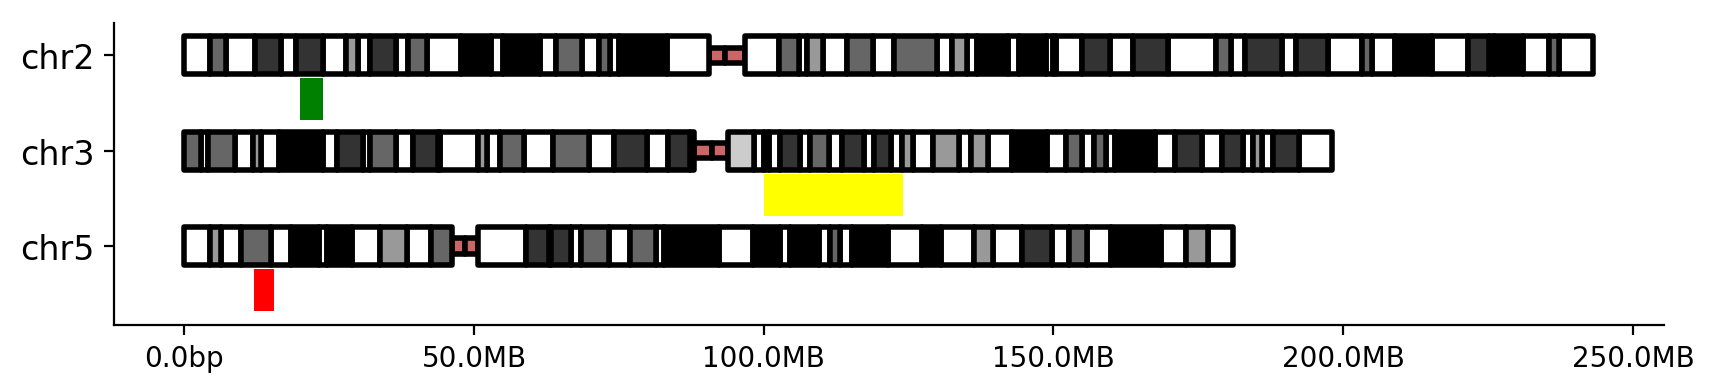

In [65]:
fig, ax = plt.subplots(figsize = (10,2), dpi = 200)
ax = draw_ideogram(regions, ideo = ideo, figsize = (10, 5), region_to_chrom=1.2, chrom_spacing = 1.5, 
                        gene_height= 1.1, ax = ax)